In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
gluonts.__version__

'0.4.2'

In [4]:
import mxnet
mxnet.__version__

'1.4.1'

In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [6]:
dataname = "m4_monthly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_monthly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/test/data.json


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 48000
length test dataset 48000


In [9]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 8000.,  8350.,  8570.,  7700.,  7080.,  6520.,  6070.,  6650.,
         6830.,  5710.,  5260.,  5470.,  7870.,  7360.,  8470.,  7880.,
         6750.,  6860.,  6220.,  6650.,  5450.,  5280.,  4970.,  5550.,
         7750.,  7760.,  7190.,  7440.,  6590.,  6210.,  6010.,  6390.,
         5780.,  5700.,  4680.,  4970.,  6850.,  6740.,  7490.,  6250.,
         6900.,  5870.,  5610.,  6310.,  6110.,  6090.,  5810.,  6060.,
         6950.,  7820.,  8270.,  7840.,  7850.,  6710.,  6220.,  7430.,
         6560.,  7080.,  6680.,  6900.,  8680.,  8450.,  8670.,  8470.,
         7910.,  8140.,  7310.,  7860.,  7730.,  7330.,  7430.,  7150.,
         8720.,  8340.,  8840.,  8780.,  8250.,  8180.,  7570.,  9280.,
         9220.,  9140.,  8950.,  8540.,  9360.,  9750.,  9270.,  8690.,
         8200.,  7610.,  7160.,  8280.,  7370.,  7130.,  6840.,  7260.,
         7430.,  7950.,  7790.,  8090.,  7480.,  6700.,  6650.,  6960.,


## Plot Series

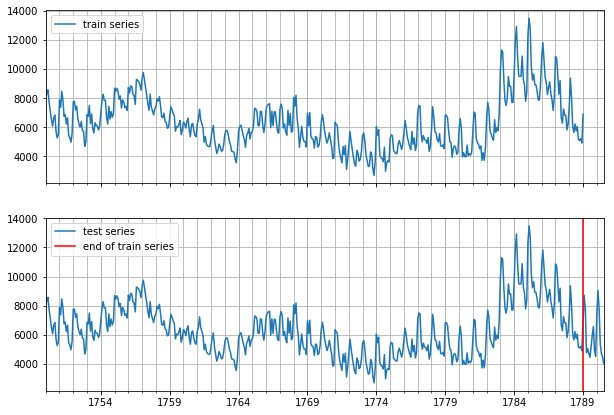

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [12]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 100/100 [00:06<00:00, 14.55it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 6.883 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.339743
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.67it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 6.385 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.593208
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.99it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 6.680 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.064031
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.49it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[3] Elapsed time 6.459 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.885445
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.63it/s, avg_epoch_los

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.562107
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 15.74it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[37] Elapsed time 6.359 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.220405
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 16.20it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[38] Elapsed time 6.178 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.130503
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 15.36it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[39] Elapsed time 6.517 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.650110
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 15.77it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 6.352 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.44

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.24it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[73] Elapsed time 6.163 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.381717
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.04it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[74] Elapsed time 6.242 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.336133
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.61it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[75] Elapsed time 6.024 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.064995
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.39it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[76] Elapsed time 5.753 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.415286
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.86it/s, avg_epoch_loss=6.49]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.92it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 5.288 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.612596
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.83it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[111] Elapsed time 5.614 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.213229
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.99it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[112] Elapsed time 5.892 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.897016
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.20it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[113] Elapsed time 5.820 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.735886
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.57it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.942593
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.82it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[147] Elapsed time 6.325 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.483937
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.45it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[148] Elapsed time 6.082 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.223253
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.04it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[149] Elapsed time 6.241 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.961318
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.46it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[150] Elapsed time 6.922 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.784333
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[183] Elapsed time 6.899 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.688744
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.43it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[184] Elapsed time 6.092 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.794486
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.37it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[185] Elapsed time 6.113 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.308059
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.28it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[186] Elapsed time 6.148 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.950412
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.99it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[187] Elapsed time

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.99it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[220] Elapsed time 6.257 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.459163
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.98it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[221] Elapsed time 6.681 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.892856
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.10it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[222] Elapsed time 6.219 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.943647
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.03it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[223] Elapsed time 6.247 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.340630
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.81it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.442852
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.94it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[257] Elapsed time 6.283 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.762918
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.53it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[258] Elapsed time 6.886 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.314041
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.02it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[259] Elapsed time 6.253 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.891253
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.12it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[260] Elapsed time 6.209 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.188623
INFO:root:Epoch[261] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 15.27it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[293] Elapsed time 6.553 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.803803
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.17it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[294] Elapsed time 6.191 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.761313
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.79it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[295] Elapsed time 6.338 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.621924
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.37it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[296] Elapsed time 6.512 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.692393
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.71it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[297] Elapsed time 

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.27it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[330] Elapsed time 5.795 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.977173
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.82it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[331] Elapsed time 5.624 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.682223
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.17it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[332] Elapsed time 5.829 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.735933
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.06it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[333] Elapsed time 5.866 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.900222
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.66it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.552247
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.02it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[367] Elapsed time 6.250 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.520898
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.14it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[368] Elapsed time 6.612 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.921547
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.10it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[369] Elapsed time 6.218 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.606679
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.98it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[370] Elapsed time 6.275 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.542379
INFO:root:Epoch[371] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 16.28it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[403] Elapsed time 6.148 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.785470
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.84it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[404] Elapsed time 6.320 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.624864
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.82it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[405] Elapsed time 6.754 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.493610
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.69it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[406] Elapsed time 6.382 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.100171
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.75it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[407] Elapsed time 6

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.52it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[440] Elapsed time 6.058 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.850653
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.22it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[441] Elapsed time 6.175 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.496253
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.83it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[442] Elapsed time 6.324 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.293639
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.83it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[443] Elapsed time 6.324 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.047520
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.82it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.562034
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.12it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[477] Elapsed time 6.212 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.535486
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.40it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[478] Elapsed time 6.104 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.832220
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.81it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[479] Elapsed time 6.331 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.557269
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.64it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[480] Elapsed time 6.399 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.466859
INFO:root:Epoch[481] Learning rate is 5e-05

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.08007  0.137514  12.07171            0.125202            0.074325    42   

   epochs  num_batches  
0     500          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 100/100 [00:05<00:00, 16.84it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 5.950 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.672763
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.36it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[1] Elapsed time 6.117 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.710754
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.09it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 6.223 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.072100
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.61it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 5.683 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.832799
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.80it/s, avg_epoch_los

100%|██████████| 100/100 [00:06<00:00, 15.96it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[37] Elapsed time 6.285 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.905380
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.94it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[38] Elapsed time 7.180 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.172745
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.44it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 6.483 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.639788
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.87it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[40] Elapsed time 6.310 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.200950
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.67it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[41] Elapsed time 6.392 seconds

100%|██████████| 100/100 [00:06<00:00, 16.01it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[74] Elapsed time 6.249 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.881898
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.98it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 6.685 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.768326
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 15.68it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[76] Elapsed time 6.383 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.285188
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 15.63it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[77] Elapsed time 6.400 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.585707
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.38it/s, avg_epoc

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.76it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[110] Elapsed time 6.349 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.375949
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.12it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[111] Elapsed time 6.212 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.913232
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.69it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[112] Elapsed time 6.380 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.856688
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.72it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[113] Elapsed time 6.802 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.931393
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.19it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.813688
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.94it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[147] Elapsed time 6.275 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.252282
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.48it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[148] Elapsed time 6.468 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.138761
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.40it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[149] Elapsed time 8.069 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.086699
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.92it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[150] Elapsed time 6.710 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.362519
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:07<00:00, 13.84it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[183] Elapsed time 7.230 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.163178
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.92it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[184] Elapsed time 6.285 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.937144
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.91it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[185] Elapsed time 6.302 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.147439
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.69it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[186] Elapsed time 6.380 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.708730
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[187] Elapsed time

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.39it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[220] Elapsed time 5.757 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.670253
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.86it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[221] Elapsed time 5.604 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.803087
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.81it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[222] Elapsed time 5.620 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.621648
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.56it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[223] Elapsed time 5.394 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.640188
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.47it/s, avg_epoch_l

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.670442
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.91it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[257] Elapsed time 6.710 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.777771
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.45it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[258] Elapsed time 6.479 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.901082
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.18it/s, avg_epoch_loss=6]
INFO:root:Epoch[259] Elapsed time 6.184 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.998576
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.45it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[260] Elapsed time 6.082 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.111452
INFO:root:Epoch[261] Learning rate is 5e-05
100

100%|██████████| 100/100 [00:07<00:00, 12.71it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[293] Elapsed time 7.870 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.986750
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[294] Elapsed time 6.611 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.666936
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[295] Elapsed time 6.606 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.556302
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.04it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[296] Elapsed time 6.652 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.778071
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.21it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[297] Elapsed time

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[330] Elapsed time 6.856 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.630244
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.86it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[331] Elapsed time 6.308 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.758256
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[332] Elapsed time 6.609 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.869036
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.00it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[333] Elapsed time 6.675 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.644354
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.45it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.507945
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.05it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[367] Elapsed time 6.653 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.159296
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.50it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[368] Elapsed time 6.460 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.533008
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.57it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[369] Elapsed time 6.429 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.786694
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.87it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[370] Elapsed time 6.733 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.586718
INFO:root:Epoch[371] Learning rate is 5e-05

100%|██████████| 100/100 [00:07<00:00, 12.59it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[403] Elapsed time 7.954 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.805332
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.80it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[404] Elapsed time 6.765 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.595231
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.95it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[405] Elapsed time 6.705 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=5.430918
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[406] Elapsed time 6.605 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.013894
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.18it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[407] Elapsed time 

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.96it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[440] Elapsed time 5.577 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.782549
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.97it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[441] Elapsed time 5.569 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.419908
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.53it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[442] Elapsed time 5.712 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.322228
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.90it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[443] Elapsed time 5.591 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.148981
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.72it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.402316
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.42it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[477] Elapsed time 6.098 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.681325
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.12it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[478] Elapsed time 6.211 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.724408
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.92it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[479] Elapsed time 6.708 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.571439
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.53it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[480] Elapsed time 6.446 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.131780
INFO:root:Epoch[481] Learning rate is 5e-05